<a href="https://colab.research.google.com/github/Melikaeydel/GSE256265/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install GEOparse


In [14]:
import GEOparse
import pandas as pd


In [15]:
gse = GEOparse.get_GEO("GSE256265", destdir="./")


23-Apr-2025 15:10:15 DEBUG utils - Directory ./ already exists. Skipping.
DEBUG:GEOparse:Directory ./ already exists. Skipping.
23-Apr-2025 15:10:15 INFO GEOparse - File already exist: using local version.
INFO:GEOparse:File already exist: using local version.
23-Apr-2025 15:10:15 INFO GEOparse - Parsing ./GSE256265_family.soft.gz: 
INFO:GEOparse:Parsing ./GSE256265_family.soft.gz: 
23-Apr-2025 15:10:15 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
23-Apr-2025 15:10:15 DEBUG GEOparse - SERIES: GSE256265
DEBUG:GEOparse:SERIES: GSE256265
23-Apr-2025 15:10:15 DEBUG GEOparse - PLATFORM: GPL23159
DEBUG:GEOparse:PLATFORM: GPL23159
23-Apr-2025 15:10:19 WARNING GEOTypes - Detected duplicated columns in d GPL23159. Correcting.


23-Apr-2025 15:10:19 DEBUG GEOparse - SAMPLE: GSM8092189
DEBUG:GEOparse:SAMPLE: GSM8092189
23-Apr-2025 15:10:19 DEBUG GEOparse - SAMPLE: GSM8092190
DEBUG:GEOparse:SAMPLE: GSM8092190
23-Apr-2025 15:10:19 DEBUG GEOparse - SAMPLE: GSM8092191
DEBUG:G

In [16]:
samples = []
for gsm_name, gsm in gse.gsms.items():
    df = gsm.table[["ID_REF", "VALUE"]].rename(columns={"VALUE": gsm_name})
    df.set_index("ID_REF", inplace=True)
    samples.append(df)

expression_data = pd.concat(samples, axis=1)


In [17]:
group_info = {}


In [18]:
tp53_wt = {
    "CTRL_24h": ["GSM8092189", "GSM8092190", "GSM8092191", "GSM8092201", "GSM8092202", "GSM8092203"],
    "RPS19_24h": ["GSM8092192", "GSM8092193", "GSM8092194", "GSM8092204", "GSM8092205", "GSM8092206"],
    "CTRL_48h": ["GSM8092195", "GSM8092196", "GSM8092197", "GSM8092207", "GSM8092208", "GSM8092209"],
    "BYSL_48h": ["GSM8092198", "GSM8092199", "GSM8092200", "GSM8092210", "GSM8092211", "GSM8092212"]
}


In [19]:
tp53_ko = {
    "CTRL_24h": ["GSM8092213", "GSM8092214", "GSM8092215", "GSM8092225", "GSM8092226", "GSM8092227"],
    "RPS19_24h": ["GSM8092216", "GSM8092217", "GSM8092218", "GSM8092228", "GSM8092229", "GSM8092230"],
    "CTRL_48h": ["GSM8092219", "GSM8092220", "GSM8092221", "GSM8092231", "GSM8092232", "GSM8092233"],
    "BYSL_48h": ["GSM8092222", "GSM8092223", "GSM8092224", "GSM8092234", "GSM8092235", "GSM8092236"]
}


In [20]:
for label, ids in tp53_wt.items():
    for gsm in ids:
        group_info[gsm] = f"TP53_WT_{label}"

for label, ids in tp53_ko.items():
    for gsm in ids:
        group_info[gsm] = f"TP53_KO_{label}"


In [21]:
expression_data = expression_data.apply(pd.to_numeric, errors='coerce')
expression_data.dropna(inplace=True)


In [22]:
import numpy as np
from sklearn.preprocessing import StandardScaler

log_data = np.log2(expression_data + 1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(log_data.T)


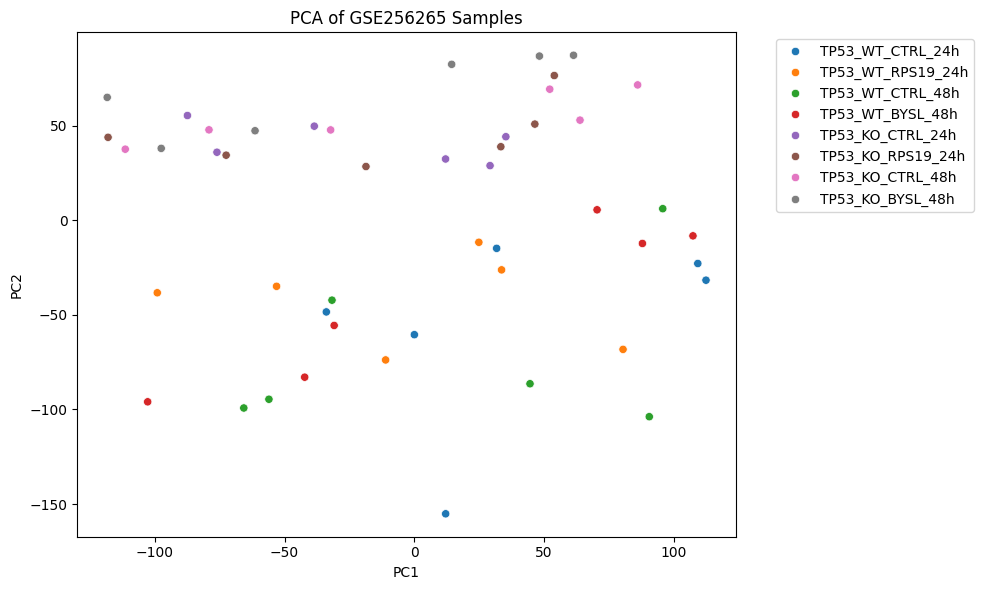

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
components = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=components[:, 0],
    y=components[:, 1],
    hue=[group_info[sample] for sample in log_data.columns],
    palette="tab10"
)
plt.title("PCA of GSE256265 Samples")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [24]:
# محاسبه واریانس برای هر ژن
variances = log_data.var(axis=1)

# انتخاب 100 ژن با بیشترین واریانس
top_genes = variances.sort_values(ascending=False).head(100).index
heatmap_data = log_data.loc[top_genes]


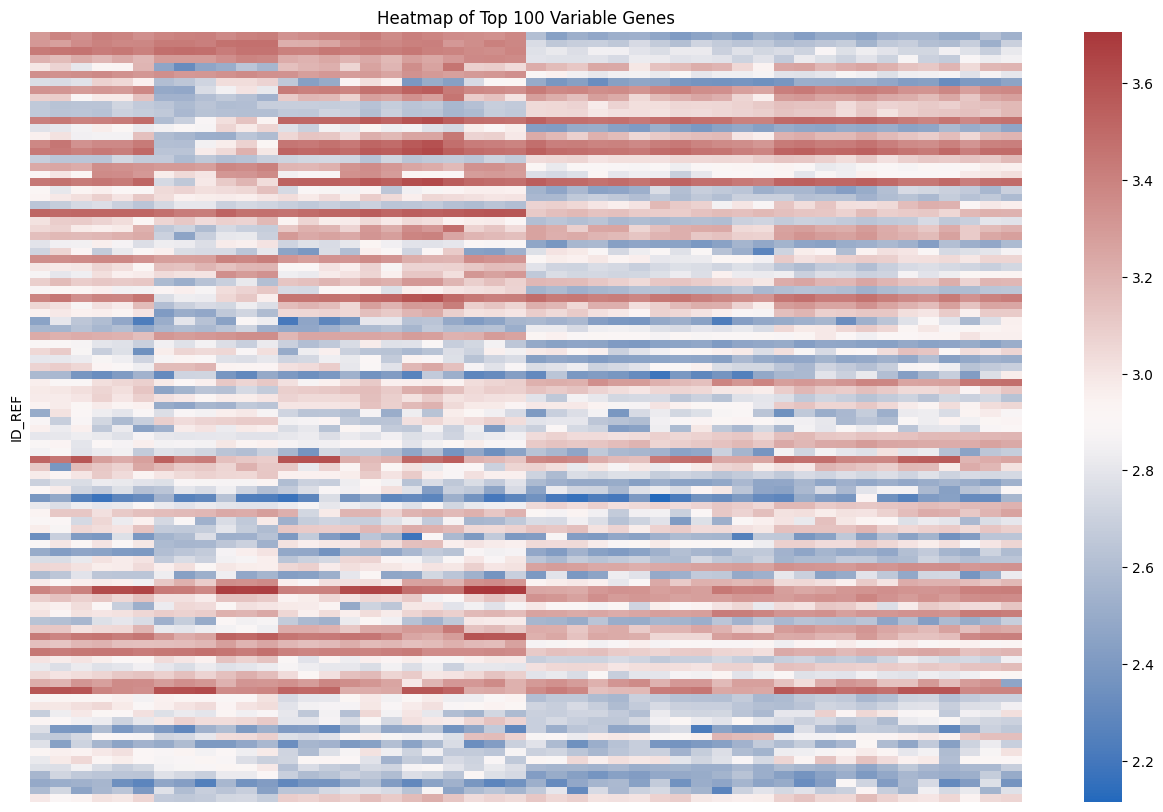

In [25]:
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data, cmap="vlag", yticklabels=False, xticklabels=False)
plt.title("Heatmap of Top 100 Variable Genes")
plt.show()


In [26]:
group_1 = [s for s in expression_data.columns if group_info[s] == "TP53_WT_CTRL_24h"]
group_2 = [s for s in expression_data.columns if group_info[s] == "TP53_WT_RPS19_24h"]


In [28]:
from scipy.stats import ttest_ind

results = []
for gene in log_data.index:
    vals1 = log_data.loc[gene, group_1]
    vals2 = log_data.loc[gene, group_2]
    t_stat, p_val = ttest_ind(vals1, vals2)
    results.append((gene, t_stat, p_val))

deg_results = pd.DataFrame(results, columns=["Gene", "t_stat", "p_value"])
deg_results["adjusted_p"] = deg_results["p_value"] * len(deg_results)  # Bonferroni correction
deg_results = deg_results.sort_values("p_value")
deg_results.head()


,Gene,t_stat,p_value,adjusted_p
24252,TC1900008164.hg.1,22.616089,6.432509e-10,0.000017
13459,TC0700009061.hg.1,-21.963318,8.575788e-10,0.000023
12307,TC0600008099.hg.1,-18.799722,3.926803e-09,0.000107
12265,TC0600007847.hg.1,-18.689588,4.158230e-09,0.000113
16155,TC0X00009215.hg.1,18.648054,4.249359e-09,0.000116


In [30]:
import numpy as np

log_data_means = log_data[group_1 + group_2].mean(axis=1)
group1_means = log_data[group_1].mean(axis=1)
group2_means = log_data[group_2].mean(axis=1)

deg_results["log2FC"] = group2_means - group1_means


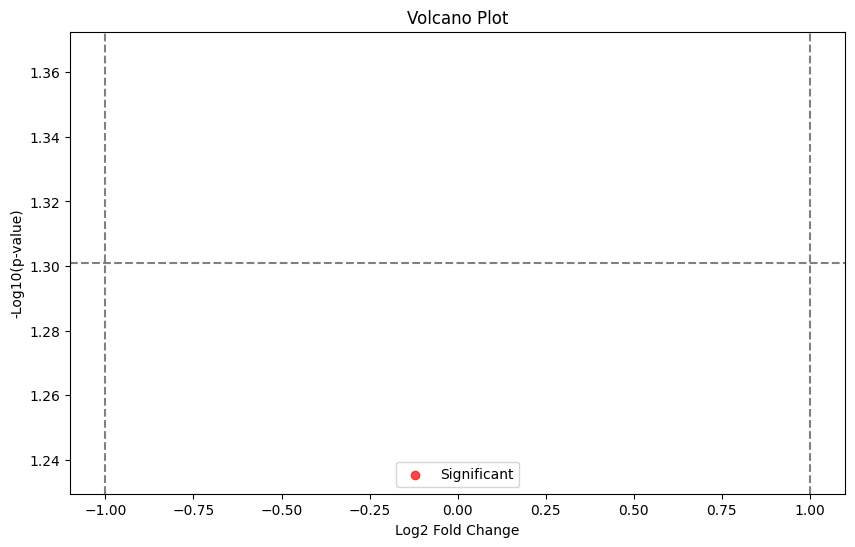

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# رسم نقاط
plt.scatter(deg_results["log2FC"], -np.log10(deg_results["p_value"]),
            alpha=0.6, edgecolor='none')

# هایلایت ژن‌های معنی‌دار
significant = (deg_results["adjusted_p"] < 0.05) & (abs(deg_results["log2FC"]) > 1)
plt.scatter(deg_results.loc[significant, "log2FC"],
            -np.log10(deg_results.loc[significant, "p_value"]),
            color='red', label='Significant', alpha=0.7)

plt.axhline(-np.log10(0.05), color='grey', linestyle='--')
plt.axvline(-1, color='grey', linestyle='--')
plt.axvline(1, color='grey', linestyle='--')

plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10(p-value)")
plt.title("Volcano Plot")
plt.legend()
plt.show()


In [32]:
deg_results.to_csv("DEG_results_TP53WT_CTRL24h_vs_RPS19.csv", index=False)
